# This is a walkthrough for performing basic analyses of methylation data

In [1]:
# Import required packages
import matplotlib.pyplot as plt
import loompy
import mop

In [2]:
# Set file information
loom_file = 'mouse_example_processing.loom'

# Visualize QC metrics for this data

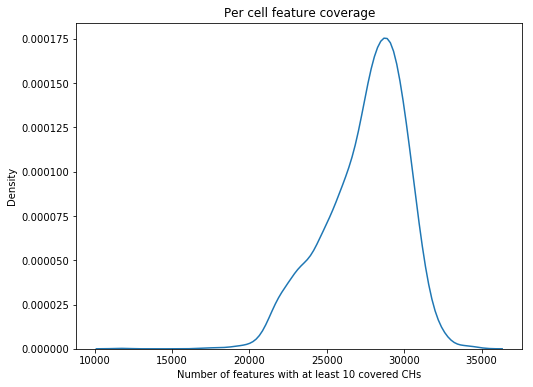

In [3]:
# Count the number of covered features per cells. 
# This function will count the number features that have at least 10 covered CH dinucleotides.
# The saved counts are stored in the row attribute "CoveredFeatures_n10"

# Get the counts
mop.qc.get_cell_coverage(loom_file=loom_file,
                         layer='CH', #Name of the layer containing counts at CH dinucleotides
                         out_attr='CoveredFeatures_n10', #Name of output row attribute
                         min_count=10, #Mininum amount of coverage for a feature to be counted
                         valid_ra=None, #We are looking at all features
                         valid_ca=None, #We are looking at all cells
                         batch_size=3000) #The loom file is read in chunks, batch_size is the size of the chunks

# Plot the distribution
mop.plot.dist_cell(loom_file=loom_file,
                   plot_attr='CoveredFeatures_n10',
                   x_label='Number of features with at least 10 covered CHs',
                   y_label='Density',
                   title='Per cell feature coverage')

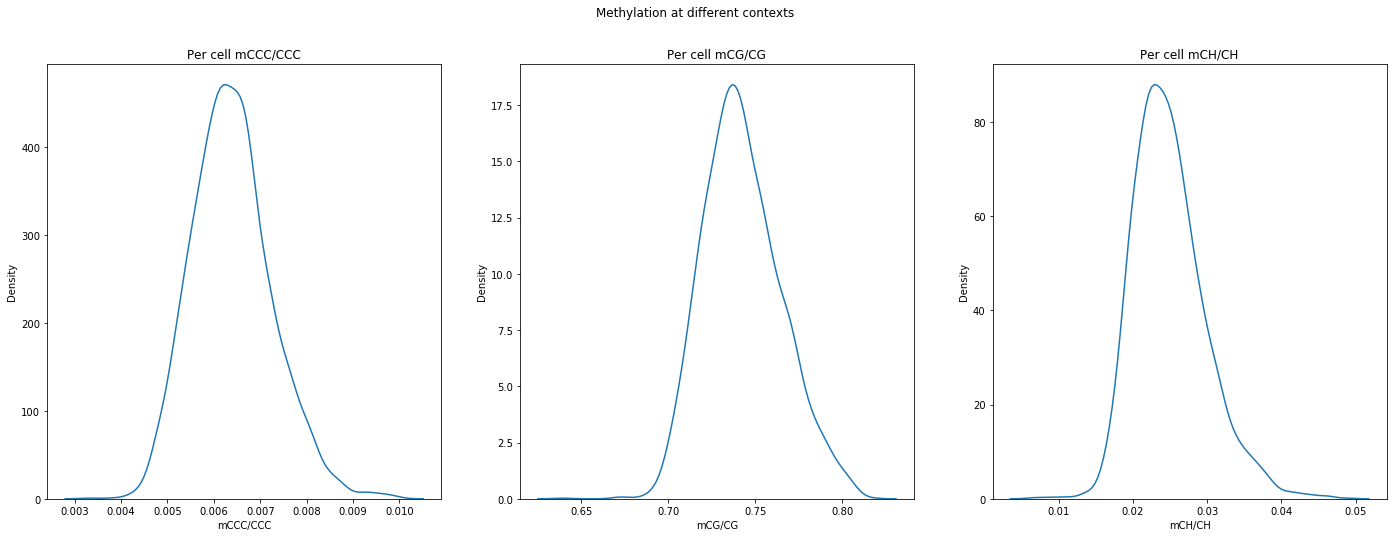

In [4]:
# Plot the distribution of methylation at different contexts (CCC, CG, and CH)
fig,axs = plt.subplots(nrows=1,ncols=3,figsize=(24,8))
mop.plot.dist_cell(loom_file=loom_file,
                   plot_attr='GlobalmCCC',
                   x_label='mCCC/CCC',
                   y_label='Density',
                   title='Per cell mCCC/CCC',
                   fig = fig,
                   ax = axs[0])
mop.plot.dist_cell(loom_file=loom_file,
                   plot_attr='GlobalmCG',
                   x_label='mCG/CG',
                   y_label='Density',
                   title='Per cell mCG/CG',
                   fig = fig,
                   ax = axs[1])
mop.plot.dist_cell(loom_file=loom_file,
                   plot_attr='GlobalmCH',
                   x_label='mCH/CH',
                   y_label='Density',
                   title='Per cell mCH/CH',
                   fig = fig,
                   ax = axs[2])
plt.suptitle('Methylation at different contexts')
plt.show()

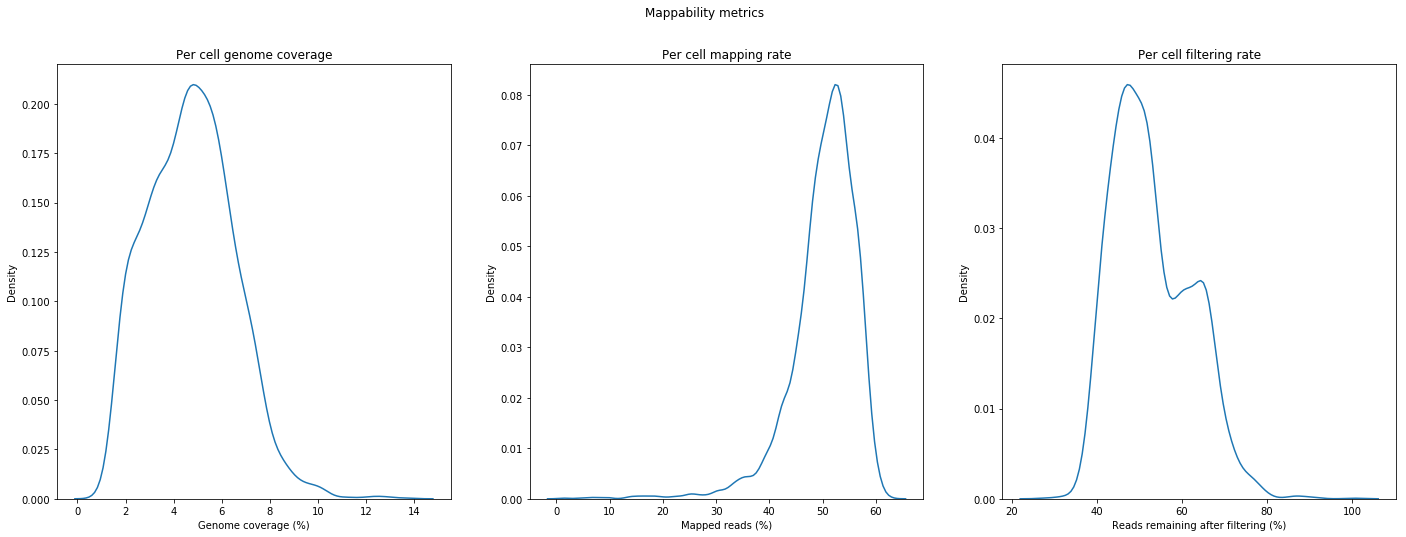

In [5]:
# Plot the distribution of different mapping metrics
fig,axs = plt.subplots(nrows=1,ncols=3,figsize=(24,8))
mop.plot.dist_cell(loom_file=loom_file,
                   plot_attr='Coverage',
                   x_label='Genome coverage (%)',
                   y_label='Density',
                   title='Per cell genome coverage',
                   fig = fig,
                   ax = axs[0])
mop.plot.dist_cell(loom_file=loom_file,
                   plot_attr='MappedRate',
                   x_label='Mapped reads (%)',
                   y_label='Density',
                   title='Per cell mapping rate',
                   fig = fig,
                   ax = axs[1])
mop.plot.dist_cell(loom_file=loom_file,
                   plot_attr='FilteredRate',
                   x_label='Reads remaining after filtering (%)',
                   y_label='Density',
                   title='Per cell filtering rate',
                   fig = fig,
                   ax = axs[2])
plt.suptitle('Mappability metrics')
plt.show()

# Find cells that pass QC

In [6]:
# Based off the plotted distributions we can now find cells that pass quality control
# Cells that pass QC will be indicated by a value of one (1) in the row attribute "Valid_QC"

# high_values are the upper limit values for the specified column attributes
# low_values are the lower limit values for the specified column attributes

mop.qc.label_cells_by_attrs(loom_file=loom_file,
                            out_attr='Valid_QC',
                            high_values={'GlobalmCCC':0.009,
                                         'Coverage':10},
                            low_values={'CoveredFeatures_n10':20000,
                                        'GlobalmCG':0.69,
                                        'GlobalmCH':0.015,
                                        'MappedRate':30,
                                        'FilteredRate':30,
                                        'Coverage':1},
                            verbose=True)

Apr-05-19  1503:45 - mop.qc - INFO - Finding valid cells for mouse_example_processing.loom
Apr-05-19  1503:45 - mop.qc - INFO - Found 3012 valid cells (96.88002573174654%) in 0.04 seconds


# Find features that pass QC

In [7]:
# We can also find features that pass QC (covered in a large enough fraction of cells)
mop.qc.label_covered_features(loom_file=loom_file,
                              layer='CH',
                              out_attr='Valid_QC',
                              min_count=10, #Needs at least 10 CH
                              fraction_covered=0.8, #Needs at least 10 CH in 80% of cells
                              valid_ca='Valid_QC',
                              valid_ra=None,
                              batch_size=3000,
                              verbose=True)

Apr-05-19  1503:46 - mop.qc - INFO - Finding valid features for mouse_example_processing.loom
Apr-05-19  1503:56 - mop.qc - INFO - Found 20684 valid features (44.16638196105227%) in 10.56 seconds


# Calculate mCH/CH

In [8]:
# When analyzing methylation data, what is of interest is the level of methylation
mop.snmcseq.calculate_mcc(loom_file = loom_file,
                          mc_layer = 'mCH',
                          c_layer = 'CH',
                          out_layer = 'mCC_CH',
                          mean_impute = True, #For features without coverage, impute mean
                          valid_ra = 'Valid_QC',
                          valid_ca = 'Valid_QC',
                          batch_size = 3000,
                          verbose = True)

Apr-05-19  1503:56 - mop.snmcseq - INFO - Calculating mC/C
Apr-05-19  1505:34 - mop.snmcseq - INFO - Calculated mC/C in 1.63 minutes


# Perform clustering and uMAP embedding

In [9]:
# We perform clustering using a louvain community detection-based method
# This wrapper will automatically:
    # perform PCA
    # generate a Jaccard weighted adjacency matrix
    # perform clustering
    # embed the data using uMAP

mop.clustering.cluster_and_reduce(loom_file,
                                  layer='mCC_CH',
                                  scale_attr='GlobalmCH',#Scaled methylation values
                                  valid_ca='Valid_QC',
                                  valid_ra='Valid_QC',
                                  batch_size=3000,
                                  verbose=True)

Apr-05-19  1505:34 - mop.decomposition - INFO - Fitting PCA
Apr-05-19  1506:22 - mop.decomposition - INFO - Fit PCA in 47.68 seconds
Apr-05-19  1506:34 - mop.decomposition - INFO - Reduced dimensions in 11.84 seconds
Apr-05-19  1506:34 - mop.neighbors - INFO - Indexing cells
Apr-05-19  1506:34 - mop.neighbors - INFO - Indexed in 0.09 seconds
Apr-05-19  1506:35 - mop.neighbors - INFO - Generated kNN in 0.98 seconds
Apr-05-19  1506:35 - mop.clustering_helpers - INFO - Converting to igraph
Apr-05-19  1506:36 - mop.clustering_helpers - INFO - Converted to igraph in 0.28 seconds
Apr-05-19  1506:36 - mop.clustering_helpers - INFO - Performing clustering with Louvain
Apr-05-19  1506:36 - mop.clustering_helpers - INFO - Clustered cells in 0.20 seconds
Apr-05-19  1506:36 - mop.decomposition - INFO - Fitting UMAP
Apr-05-19  1506:47 - mop.decomposition - INFO - Obtained UMAP in 11.29 seconds


# Plot the results

In [10]:
# Report how many clusters we obtained
with loompy.connect(loom_file) as ds:
    clusters = np.unique(ds.ca['ClusterID'][ds.ca['Valid_QC'].astype(bool)])
print('{} clusters were identified'.format(clusters.shape[0]))

20 clusters were identified


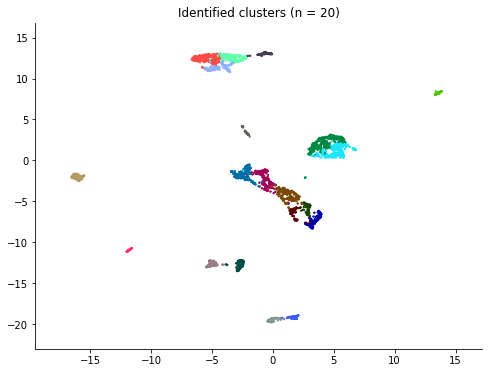

In [11]:
# How do clusters separate on the embedding?
mop.plot.scatter_cell(loom_file=loom_file,
                      x_axis = 'umap_x',
                      y_axis = 'umap_y',
                      plot_attr = 'ClusterID',
                      legend = False,
                      valid_ca = 'Valid_QC',
                      title = 'Identified clusters (n = {})'.format(clusters.shape[0]))

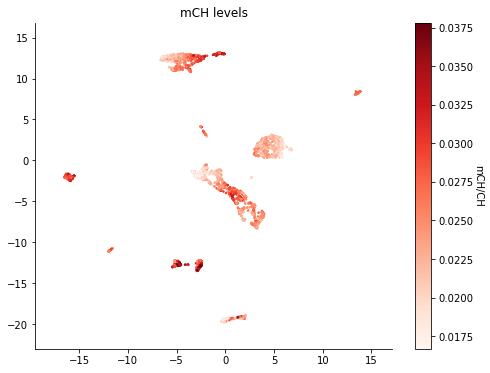

In [12]:
# Are there differences in methylation across clusters?
mop.plot.scatter_cell(loom_file=loom_file,
                      x_axis = 'umap_x',
                      y_axis = 'umap_y',
                      plot_attr = 'GlobalmCH',
                      legend = False,
                      as_heatmap=True,
                      cbar_label='mCH/CH',
                      valid_ca = 'Valid_QC',
                      cmap = 'Reds',
                      title = 'mCH levels')

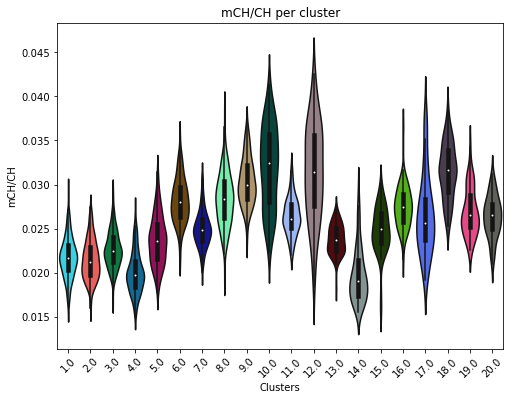

In [13]:
# Are there differences in methylation across clusters?
mop.plot.violinplot_cell(loom_file=loom_file,
                         category_attr='ClusterID',
                         value_attr='GlobalmCH',
                         valid_ca='Valid_QC',
                         x_label='Clusters',
                         y_label='mCH/CH',
                         title='mCH/CH per cluster')

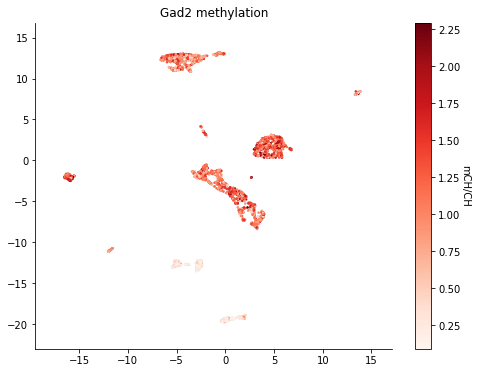

In [14]:
# Can we identify GABAergic interneurons (they should have low methylation at Gad2)
mop.plot.scatter_feature(loom_file=loom_file,
                         x_axis='umap_x',
                         y_axis='umap_y',
                         feat_id='Gad2',
                         layer='mCC_CH',
                         feat_attr='Name',
                         scale_attr='GlobalmCH',
                         valid_ca='Valid_QC',
                         title='Gad2 methylation',
                         cbar_label='mCH/CH',
                         gray_noncoverage=True, #Any cell without coverage will be gray
                         coverage_layer='CH',
                         cmap = 'Reds')

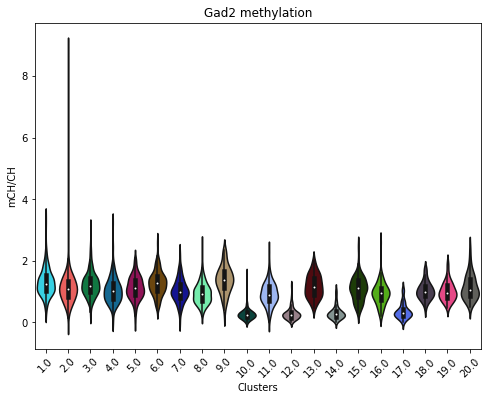

In [15]:
# Can we identify GABAergic interneurons (they should have low methylation at Gad2)
mop.plot.violinplot_feature(loom_file,
                            category_attr='ClusterID',
                            feat_id='Gad2',
                            layer='mCC_CH',
                            feat_attr='Name',
                            scale_attr='GlobalmCH',
                            valid_ca='Valid_QC',
                            x_label='Clusters',
                            y_label='mCH/CH',
                            title='Gad2 methylation')